## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")



MPS is enabled!
MPS is enabled!


### 1. Generate data from Archimedean spiral

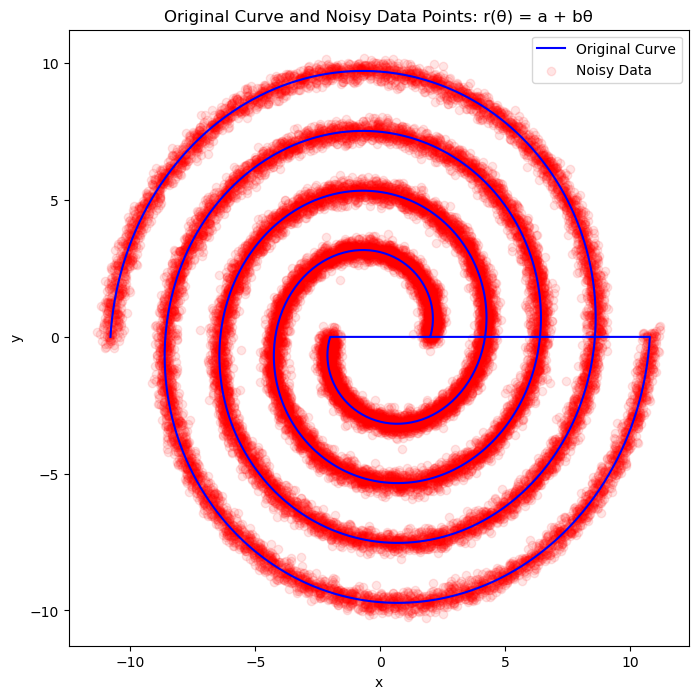

In [2]:
data = GenerateDataset()

## 2. Sparse coding

In [3]:
data_tensor = torch.tensor(data, dtype=torch.float,device = device)

# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=300, sparsity_level=0)


# Define optimizer for Biasis update
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 3000

# Training loop
for epoch in range(num_epochs):

    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

    if cost <= 1e-2:
        print('training ended!')
        break

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)



Epoch [10/3000], Cost = 0.4069478213787079
Epoch [20/3000], Cost = 0.3269331753253937
Epoch [30/3000], Cost = 0.2665828764438629
Epoch [40/3000], Cost = 0.22256384789943695
Epoch [50/3000], Cost = 0.19043925404548645
Epoch [60/3000], Cost = 0.16682322323322296
Epoch [70/3000], Cost = 0.14970092475414276
Epoch [80/3000], Cost = 0.13686180114746094
Epoch [90/3000], Cost = 0.12655340135097504
Epoch [100/3000], Cost = 0.1189560815691948
Epoch [110/3000], Cost = 0.11346730589866638
Epoch [120/3000], Cost = 0.10914021730422974
Epoch [130/3000], Cost = 0.10530535876750946
Epoch [140/3000], Cost = 0.10213025659322739
Epoch [150/3000], Cost = 0.10001976788043976
Epoch [160/3000], Cost = 0.09862538427114487
Epoch [170/3000], Cost = 0.09755639731884003
Epoch [180/3000], Cost = 0.09662915766239166
Epoch [190/3000], Cost = 0.09583377838134766
Epoch [200/3000], Cost = 0.09518290311098099
Epoch [210/3000], Cost = 0.09466259926557541
Epoch [220/3000], Cost = 0.09419138729572296
Epoch [230/3000], Cost 

### Plot learnt dictionary and clustered data points

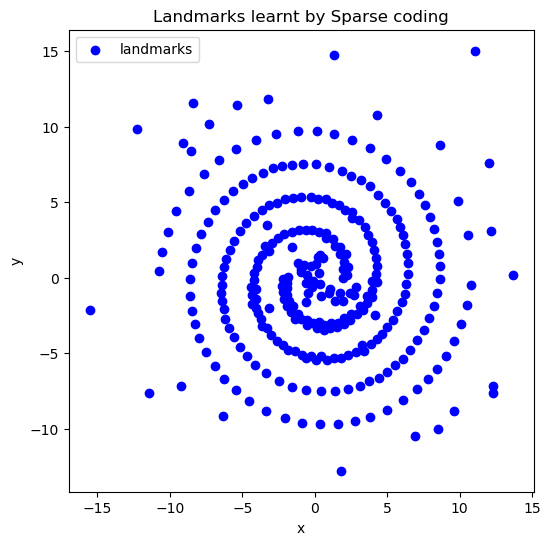

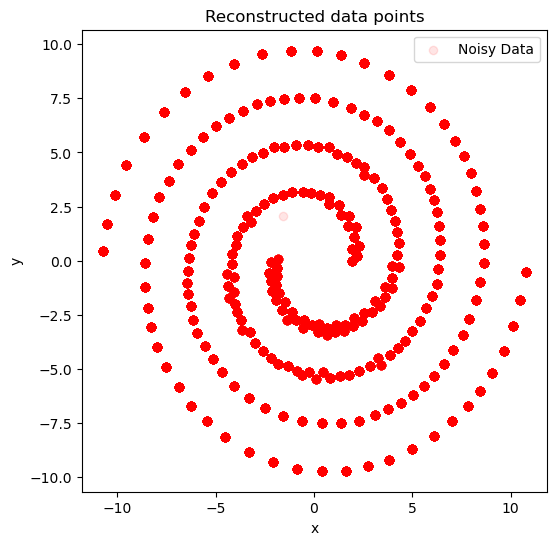

1.0


In [4]:

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[6, 6])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Reconstructed data points")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


## 2. Assign similarity (Define D)

### 2.1 K-nearest neighbours in dictionary (B)

In [9]:
## Compute K-nearest neighbors for each element in model.Basis

# Compute K-nearest neighbors
neighbors_indices = model.KNN(3).detach().cpu()
print("K-nearest neighbors indices:")
print(neighbors_indices)

K-nearest neighbors indices:
tensor([[ 53,  55, 114],
        [ 12,  33,  24],
        [237, 200, 294],
        [167, 258, 284],
        [ 89, 216,  37],
        [226, 235,  47],
        [154, 111,  41],
        [247,  62, 204],
        [ 53, 214,   0],
        [137, 221,  17],
        [ 15,  34, 240],
        [277,  88, 135],
        [  1,  57, 260],
        [250,  20, 106],
        [ 41, 188, 154],
        [240,  10,  92],
        [ 70, 234, 299],
        [221,  26,   9],
        [ 22,  69,  40],
        [171, 167,  70],
        [195,  13, 250],
        [161, 175, 151],
        [ 40,  18,  48],
        [228, 220, 267],
        [ 33, 265, 298],
        [ 87,  84,  90],
        [ 17, 149,   9],
        [129, 178, 166],
        [ 97, 213,  30],
        [273, 248,  73],
        [213, 140, 231],
        [ 61,  35, 225],
        [210, 109, 257],
        [ 24,   1, 265],
        [ 47,  10,  15],
        [ 31, 150, 245],
        [ 21, 161, 229],
        [216, 175,   4],
        [285,  54, 28

torch.Size([3, 2])
torch.Size([3, 2])


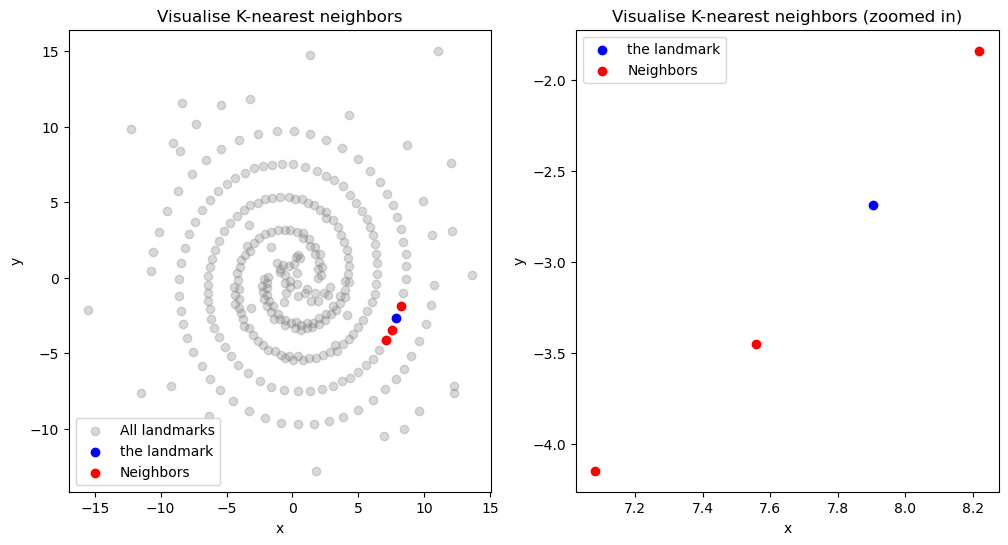

In [10]:
## plot neighbors for a landmark
idx = 200

fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

# plot dictionary elements
ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', color='gray', alpha=0.3)

ax.scatter(Bas[idx,0], Bas[idx,1], label='the landmark', color='blue', alpha=1)
neighbors = Bas[neighbors_indices[idx],:]
print(neighbors.shape)
ax.scatter(neighbors[:,0], neighbors[:,1], label='Neighbors', color='red', alpha=1)

# Setting the title and labels
ax.set_title("Visualise K-nearest neighbors")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

ax1.scatter(Bas[idx,0], Bas[idx,1], label='the landmark', color='blue', alpha=1)
neighbors = Bas[neighbors_indices[idx],:]
print(neighbors.shape)
ax1.scatter(neighbors[:,0], neighbors[:,1], label='Neighbors', color='red', alpha=1)

# Setting the title and labels
ax1.set_title("Visualise K-nearest neighbors (zoomed in)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
plt.show()


### 2.2 Construct D from B
Goal: minimising distance between neighbours


### !!Skipped due to dimension issue!!

In [ ]:
# a = torch.zeros(7,4,7)
# b = torch.zeros(7,5)

# print((a@b@b.T@a.T).shape)
# # print(a.shape)
# # print(((a@a).shape))

Goal: keep topology by using interpolation (LLE on dictionary elements)

In [11]:
## Weight matrix

Basis = model.Basis.detach()

neighbors = Basis[neighbors_indices,:] # (700,k,2)

print('neighbors shape: ', neighbors.shape)

local_cov = (Basis.unsqueeze(1)-neighbors) @ torch.transpose((Basis.unsqueeze(1)-neighbors), dim0=1, dim1=2) # (700,k,k)=(700,k,2)@(700,2,k)
local_cov_inv = torch.inverse(local_cov) # (700,k,k)

print(local_cov[1]@local_cov_inv[1])
weight = torch.sum(local_cov_inv,dim=1) / torch.sum(local_cov_inv,dim=[1,2]).unsqueeze(1) #(700,k)

print('weight: ', weight.unsqueeze(-1).shape)
recon_landmark = torch.transpose(neighbors,dim0=1,dim1=2) @ weight.unsqueeze(-1) # (700,2,k) @ (700,k,1)
recon_landmark.squeeze_(2)
print(recon_landmark.shape)
print('interpolation error: ')
print(recon_landmark - Basis)

# check sum of weight
print(torch.sum(weight,dim=1))


neighbors shape:  torch.Size([300, 3, 2])
tensor([[ 1.0683, -2.6932,  1.0793],
        [-0.0210,  2.5277, -1.6309],
        [ 0.4603, -0.0638, -1.7656]], device='mps:0')
weight:  torch.Size([300, 3, 1])
torch.Size([300, 2])
interpolation error: 
tensor([[-4.7684e-07,  4.7684e-07],
        [ 4.7684e-07, -2.9802e-08],
        [-1.9073e-06,  7.1526e-07],
        [ 0.0000e+00,  0.0000e+00],
        [ 9.5367e-07,  2.3842e-07],
        [-1.4901e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  5.9605e-08],
        [ 0.0000e+00,  4.7684e-07],
        [ 4.7684e-07, -1.1921e-07],
        [ 0.0000e+00,  2.9802e-08],
        [ 0.0000e+00, -1.1921e-07],
        [-2.8610e-06,  1.4305e-06],
        [ 0.0000e+00,  4.7684e-07],
        [-9.5367e-07,  0.0000e+00],
        [ 0.0000e+00,  2.9802e-08],
        [ 0.0000e+00, -9.5367e-07],
        [ 5.7220e-05, -1.0777e-04],
        [-2.3842e-07,  1.1921e-07]

torch.Size([300, 3])
torch.Size([300, 3])
tensor([-1.6014e-08,  5.7644e-07])


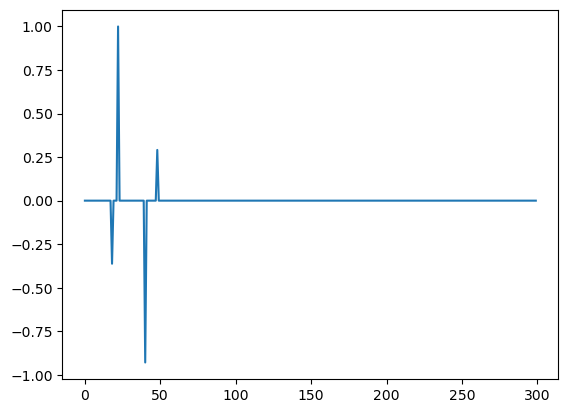

In [12]:
print(neighbors_indices.shape)
print(weight.shape)
Diff = torch.eye(Basis.shape[0],Basis.shape[0], device=device)

# Iterate over each row (each landmark)
for i in range(neighbors_indices.size(0)):
    # Select vaelements from Diff based on indices and apply weights
    Diff[i, neighbors_indices[i]] -= weight[i]


# Validation 
diff = Diff.cpu()[22]
plt.plot(diff)
print(Bas.T @ diff)

### 2.3 Solve generalised eigenvalue proble

In [13]:
Diff = Diff.cpu()

/var/folders/tr/k4p6cxld3ql638sby8p0sr500000gn/T/ipykernel_76570/3894663364.py:3: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1704987089515/work/aten/src/ATen/native/Copy.cpp:301.)
  Diff_eigenvalues = Diff_eigenvalues.to(torch.float32)


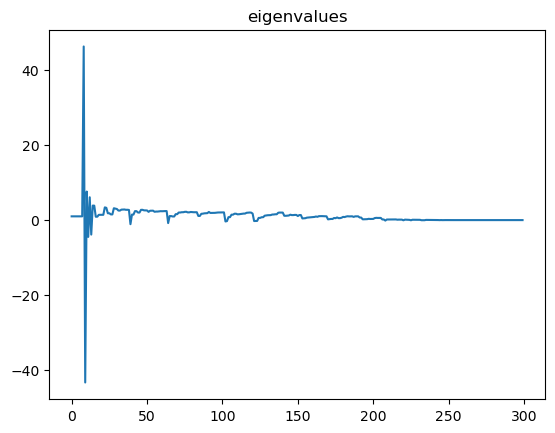

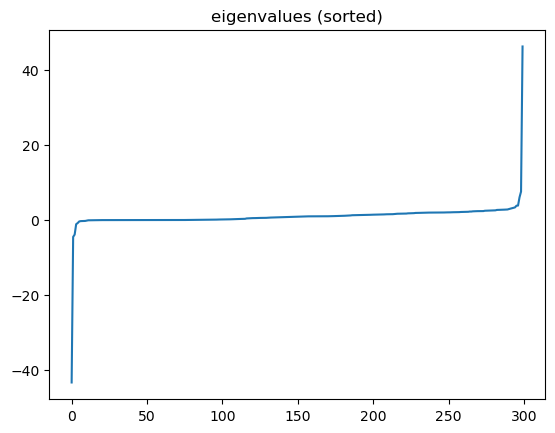

tensor(300.0001)


In [14]:
Diff_eigenvalues, Diff_eigenvectors = torch.linalg.eig(Diff)

Diff_eigenvalues = Diff_eigenvalues.to(torch.float32)
Diff_eigenvectors = Diff_eigenvectors.to(torch.float32)

plt.figure()
plt.plot(Diff_eigenvalues)
plt.title('eigenvalues')
plt.show()

d = 4 # dimension of final embedding space

sorted_indices = torch.argsort(Diff_eigenvalues)
sorted_eigenvalues = Diff_eigenvalues[sorted_indices]
sorted_eigenvectors = Diff_eigenvectors[:, sorted_indices]

plt.figure()
plt.plot(sorted_eigenvalues)
plt.title('eigenvalues (sorted)')
plt.show()


print(torch.sum(sorted_eigenvalues)) ## TODO: Why????????????

In [15]:
## Now find P

A = model.Activ.detach().cpu()

#  Compute eigenvalue decomposition of A
ATA_eigenvalues,ATA_eigenvectors = torch.linalg.eigh(A.T@A)

# Square root of eigenvalues
ATA_sqrt_eigenvalues = torch.sqrt(ATA_eigenvalues)

# Reconstruct square root of A from eigenvalues and eigenvectors
sqrt_ATA = ATA_eigenvectors @ torch.diag(ATA_sqrt_eigenvalues) @ ATA_eigenvectors.t()
inv_sqrt_ATA = torch.pinverse(sqrt_ATA)

raw_P = inv_sqrt_ATA @ sorted_eigenvectors[:,0:d]

# Normalize each column 
raw_P = raw_P / torch.norm(raw_P, dim=0) 


P = raw_P.T @ inv_sqrt_ATA / inv_sqrt_ATA.size(0)**0.5
print(P.shape)

print(P)

torch.Size([4, 300])
tensor([[ 8.4702e-12,  1.5501e-15,  3.5402e-11,  ..., -6.2897e-14,
         -1.9560e-21,  5.9072e-18],
        [ 1.2842e-08, -2.0383e-17, -2.5587e-12,  ...,  7.0410e-13,
         -4.9887e-23,  1.0983e-21],
        [-9.4210e-19,  6.5323e-20,  6.9840e-18,  ..., -6.9619e-21,
         -1.7985e-22, -3.1845e-17],
        [ 6.3469e-18, -2.5218e-18, -5.6579e-17,  ..., -8.8650e-19,
         -1.1595e-17, -1.5828e-17]])


### 2.4 Visualise P

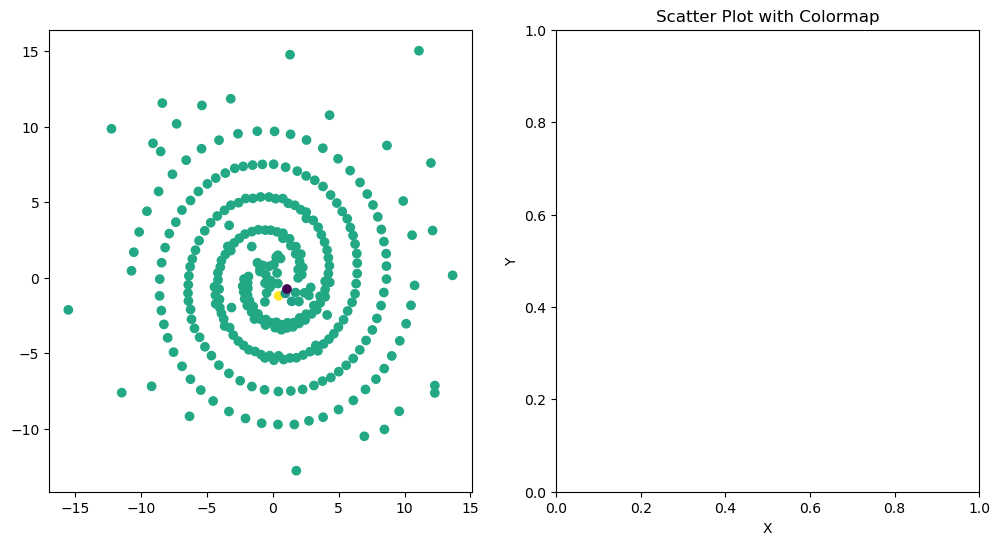

In [20]:
# Example data
idx = 3
fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

colors = P.cpu()[idx]
colors = (colors - torch.min(colors)) / (torch.max(colors) - torch.min(colors))

cmap = 'viridis'  # Example colormap

# plot dictionary elements using first row of P
ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=colors, cmap=cmap)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Colormap')
plt.show()